In [1]:
import numpy as np
import numpy.random as rd
import torch
from torch import nn
from torch import optim
import torch.utils.data as load_data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# HELPER FUNCTIONS #
def sigmoid(y):
    """sigmoid function"""
    return 1 / (1 + np.exp(-y))

In [3]:
# Load MNIST data
train_data = torchvision.datasets.MNIST('MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_data = torchvision.datasets.MNIST('MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
# Get images of 0s and 1s
mnist_zeros = train_data.data[train_data.targets == 0]
mnist_ones = train_data.data[train_data.targets == 1]
# Shuffle them into a training data set
shuffle_index = rd.permutation(np.arange(len(mnist_zeros) + len(mnist_ones)))
regression_data = np.vstack([mnist_zeros.reshape([-1, 28 ** 2]), mnist_ones.reshape([-1, 28 ** 2])])[shuffle_index]
regression_data_labels = np.hstack([np.zeros(len(mnist_zeros)), np.ones(len(mnist_ones))])[shuffle_index]

# Deep Learning Tutorial Part I: Stochastic Gradient Descent

In this notebook, we'll try to solve the classic MNIST classification problem. The problem is to classify black-and-white images of hand-written digits, e.g. a hand-written number 1 should be classified as a 1, a hand-written number 5 should be classified as a 5, and so on. Some examples are below. Such problems are called **classification** problems, since each image is assigned a particular class.

![alt text](http://varianceexplained.org/images/mnist.png)

The way this is classically done in machine learning - and the way we'll do this here - is by building a **model** $f_\theta(\mathbf{x})$, which takes as input an image $\mathbf{x}$ and outputs a set of probabilities corresponding to the probability that the image is of each class.

Note the particular way in which I have mathematically expressed the model, with a subscript $\theta$. This subscript is meant to indicate the **parameters** of the model, which we'll need to learn in order to get good classifications. In the cases we'll explore here, the models will all be feed-forward neural networks, so their parameters $\theta$ are just the connection strengths between each layer of neurons. 

A priori, we have no idea what these connection strengths should be. So we'll use a particular algorithm called **stochastic gradient descent (SGD)** to learn them. 

We begin by defining our model...

## <span style="color:blue"> Logistic Regression </span>

We'll start out by classifying only two digits: 1's and 0's. We'll do this is by using a **linear model** that takes a weighted summation of the grayscale values $x_i$ of each of the pixels in the image and transforms this into a probability of the image $\mathbf{x}$ being that of a hand-written number 1:
\begin{gather*}
    f_\mathbf{w}(\mathbf{x}) = g\left(\mathbf{w}^T\mathbf{x}\right) = g\left( \sum_i w_i x_i \right) \\
    g(y) = \frac{1}{1 + e^{-y}} \\
\end{gather*}
such that
\begin{gather*}
    P(\text{image } \mathbf{x} \text{ is of class 1}) = f_\mathbf{w}(\mathbf{x}) \\
    P(\text{image } \mathbf{x} \text{ is of class 0}) = 1 - f_\mathbf{w}(\mathbf{x})
\end{gather*}
where "is of class $c$" means "is an image of a hand-written number $c$". A more succinct way of writing this is:
\begin{equation}
    P(\text{image } \mathbf{x} \text{ is of class } c) = f_\mathbf{w}(\mathbf{x})^c \left(1 - f_\mathbf{w}(\mathbf{x}) \right)^{1-c}
\end{equation}
since $c$ can only take on a value of 0 or 1 (if you're skeptical, plug in 0 and 1 for $c$ and check that this expression is the same as the two above!).

This model is depicted in the figure below. The parameters of this model are just the linear weights $\mathbf{w}$, which we'll learn by gradient descent. Finding the weights $\mathbf{w}$ that maximize classification accuracy is also called **logistic regression**, due to the similarity of this model to linear regression but with the extra addition of the so-called **logistic function** $g(\cdot)$ (also referred to as the **sigmoid function**), needed to convert the output of the linear model into a probability.

<img src="logistic_regression.png" style="height: 300px;"/>

## <span style="color:blue"> Stochastic Gradient Descent </span>
Recall that we want to find the weights $\mathbf{w}$ that maximize classification accuracy. We'll do this by fitting the weights to some **training data** consisting of image-class pairs, i.e. a bunch of images of hand-written 1's and hand-written 0's paired with their corresponding class labels:
\begin{gather*}
    \{\mathbf{x}^{(i)}, c^{(i)}\}_{i=1}^N
\end{gather*}
This denotes a set of $N$ images $\mathbf{x}^{(i)}$ paired with corresponding class labels $c^{(i)}$, which, as above, take the value
\begin{equation}
    c^{(i)} = 
    \begin{cases}
        1 & \text{if } \mathbf{x}^{(i)} \text{ is an image of a hand-written 1} \\
        0 & \text{if } \mathbf{x}^{(i)} \text{ is an image of a hand-written 0}
    \end{cases}
\end{equation}

We'll fit the weights to these training data by maximizing the log probability of the classes of each of these images. In fact, what we'll do is ***minimize* the *negative* log probability**, which is exactly equivalent. The only reason for this is that machine learning people prefer to minimize things than to maximize things (because often they are minimizing some measure of *error*), so the Python packages they develop for machine learning are built to minimize things. 

We'll thus call the negative log probability the **loss function** $\mathcal{L}(\mathbf{w})$ that we want to minimize with respect to the network weights $\mathbf{w}$. It is a function of $\mathbf{w}$ because the probabilities of the true image classes used to compute it are the outputs of the network with those weights. This is made evident by explicitly writing out the loss function evaluated at a given set of image-class pairs:
\begin{align*}
    \mathcal{L}(\mathbf{w}) &= -\sum_i \log P\left(\text{image }\mathbf{x}^{(i)} \text{ is of class }c^{(i)}\right) \\
    &= -\sum_i \log \left( f_\mathbf{w}(\mathbf{x}^{(i)})^{c^{(i)}} \left(1 - f_\mathbf{w}(\mathbf{x}^{(i)}) \right)^{1-c^{(i)}} \right) \\
    &= -\sum_i c^{(i)}\log f_\mathbf{w}\left(\mathbf{x}^{(i)}\right) + (1 - c^{(i)})\log \left( 1 - f_\mathbf{w}\left(\mathbf{x}^{(i)}\right)\right)
\end{align*}

To minimize this loss function, we'll use the following algorithm:
1. Pick a random subset of $M$ image-class pairs $\{\mathbf{x}^{(i)}, c^{(i)}\}_{i = 1}^M$ from the training data. This random subset of training data is called a **batch**.
2. Evaluate the objective function at the data in the batch (i.e. the above sum over $i$ will sum over the data points in the batch only) and compute the derivative of the loss function with respect to the weights:
\begin{equation}
    \frac{\partial \mathcal{L}}{\partial \mathbf{w}} = -\sum_i \left(c^{(i)} - f_\mathbf{w}\left(\mathbf{x}^{(i)}\right)\right) \mathbf{x}^{(i)}
\end{equation}
where again the sum is over images and labels in the batch only. If you like math try deriving this expression yourself!
3. Change the weights in the *opposite* direction of the gradient, in order to decrease the loss function *smaller*:
\begin{gather}
    \mathbf{w} \leftarrow \mathbf{w} - \Delta \mathbf{w} \\
    \Delta \mathbf{w} = \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{w}}
\end{gather}
This weight update $\Delta \mathbf{w}$ is scaled by a learning rate $\alpha > 0$, to regulate how big the updates are. Weight updates that are too large can be unstable, and weight updates that are too small will take too long to minimize $\mathcal{L}(\mathbf{w})$, so it is important to set this learning rate at the right level.
4. Repeat steps 1-3 until $\mathcal{L}(\mathbf{w})$ gets as small as possible.

This algorithm for finding the weights $\mathbf{w}$ minimizing the loss function $\mathcal{L}(\mathbf{w})$ is called <ins>stochastic</ins> <ins>gradient</ins> <ins>descent</ins>, because we're updating the weights at each iteration by *descending* along the *gradient* evaluated at a *stochastically* selected subset of data points from the full training data (i.e. the batch). One could instead do non-stochastic gradient descent (simply called gradient descent) by evaluating the gradient of the objective function at all data points simultaneously, but it turns out that the stochastic version of gradient descent typically performs much better on harder problems.

### 1.1) Perform stochastic gradient descent for the linear model

Fill in the code below to perform stochastic gradient descent to learn the weights of this model. Save the loss at each iteration and then plot it. Use the above-defined helper function `sigmoid()` to implement the last stage of the model.

The data to be used are in the variables 
* `regression_data`, an $N \times 784$ matrix containing the grayscale values of the 784 pixels of each image in this data set of $N$ images, and
* `regression_data_labels`, an $N$-dimensional vector containing the labels (1 or 0) of each of these images.

Feel free to play around with the SGD parameters set in the next cell and see what happens:
1. What happens when you increase the learning rate?
2. What happens when you decrease the batch size?

In [4]:
# SGD Parameters
batch_size = 50 # how much data to include in each batch
n_iter = 1000 # how many iterations of gradient descent to perform
alpha = 1e-8 / batch_size # learning rate

# Loss function
def loss_fn(p, batch_labels):
    return - np.sum(batch_labels * np.log(p) + (1 - batch_labels) * np.log(1 - p))

In [5]:
# Initialize weights
n_pixels = 784 # how many pixels in each image
w = np.zeros(n_pixels)

# Placeholder for the loss
track_loss = np.zeros(n_iter)

# Loop over iterations
for i in range(n_iter):
    if i % 250 == 0: # every 250 iterations print the percent of iterations completed
        print('%.0f%% iterations completed...' % (100 * (i+1) / n_iter))
    # Sample random batch
    batch_index = rd.choice(len(regression_data), batch_size, replace=False)
    batch_images = regression_data[batch_index]
    batch_labels = regression_data_labels[batch_index]
    # Run the model on this batch of images to calculate estimated class probabilities
    p = np.zeros(batch_size)
    for j, image in enumerate(batch_images):
        p[j] = sigmoid(np.matmul(image, w))
    # Compute loss for this batch
    track_loss[i] = loss_fn(p, batch_labels)
    # Compute gradient of loss
    dw = np.zeros(n_pixels) # gradient
    for image, label, prob in zip(batch_images, batch_labels, p):
        dw += - (label - prob) * image
    # Implement weight update
    w -= alpha * dw

0% iterations completed...
25% iterations completed...
50% iterations completed...
75% iterations completed...


Text(0, 0.5, 'objective function')

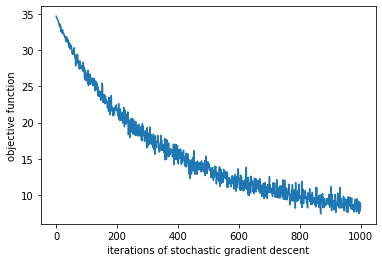

In [6]:
# Plot the loss
fig, ax = plt.subplots()
ax.plot(track_loss)
ax.set_xlabel('iterations of stochastic gradient descent')
ax.set_ylabel('objective function')

### 1.2) Interpret the learned weights.

First, take a minute to stare at the equations defining the model and think about what each stage of the model is doing. In particular, how can we interpret the output of the linear operation? Can you get an intuition for what the weights should be in order to correctly classify images of 1's and 0's? (clue: think of the linear summation as a dot product!) 

Next, take a minute to stare at the equations for the weight update. Given you answer to the previous questions, can you intuitively tell why this might be a good weight update?

Lastly, use the code below to plot the learned weights as an image - does the result agree with your answers to the previous two questions?

([], <a list of 0 Text yticklabel objects>)

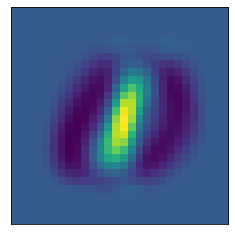

In [8]:
plt.imshow(np.reshape(w, (28, 28))) # display weight vector w as a 28 x 28 pixel image
plt.xticks([])
plt.yticks([])

### <span style="color:blue"> PyTorch and automatic differentiation </span>
PyTorch is a Python package that is super useful for deep learning and machine learning in general. The main advantages of it are:
1. It has a lot of built-in functions for building deep learning models, for example in the `nn` and `optim` libraries.
2. It can compute gradients automatically using the `.backward()` function.

This last point is the real kicker, since gradients can get really hard to calculate when your model gets more complicated. Because it can compute these automatically, it frees you of both (i) having to do the math to derive the gradient and (ii) having to write the code to calculate it. It also has uses algorithms to calculate it very efficiently. What it all comes down to is an algorithmic technique called automatic differentiation, which effectively computes the gradients of every operation performed by your model and stitches them together using the chain rule to get the derivative of the model's output with respect to its parameters. Automatic differentiation is what all the top deep learning packages specialize in doing, including PyTorch, Tensorflow, and others.

Here's some PyTorch code to to build the above logistic regression model. Take a moment to examine it to understand what's going on in each line.

In [9]:
n_pixels = 784 # number of pixels in each image
class logistic_model(nn.Module):
    """
    This Python class builds a PyTorch model. 
    By making of type nn.Module, it inherits all the nice automatic differentiation properties of PyTorch models
    """
    def __init__(self): 
        """This function initializes the model"""
        super(logistic_model, self).__init__()
        self.linear = nn.Linear(n_pixels, 1, bias=False) # initializes the linear weights

    def forward(self, x):
        """This function runs the model on a set of images x"""
        y = self.linear(x)
        p = torch.sigmoid(y)
        return p

### 1.3) Check that the PyTorch implementation does the same thing as the numpy implementation
Run each model on some random images and check that their outputs are the same when initialized with the same set of weights. One slightly annoying thing about PyTorch is that it doesn't use normal numpy arrays, it has its own types of matrices and vectors called *tensors*. So when taking a PyTorch variable and doing numpy operations on it, it is always necessary to first transform it into a numpy array.

In [10]:
# Initialize PyTorch model
torch_model = logistic_model()

# Retrieve its initialized weights to compare to numpy implementation with same setting of weights
w = torch_model.linear.weight.detach().numpy() # transform to numpy array

In [11]:
# Placeholders for model outputs
out_torch, out_np = [], []

# Loop through all the data
for x in regression_data:
    # Compute model output using torch
    out_torch.append(torch_model(torch.Tensor(x)).detach().numpy())
    # Compute model output using numpy
    out_np.append(sigmoid(np.matmul(w, x)))

/Users/jorgeamenendez/.virtualenvs/ccnss_tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Text(0, 0.5, 'pytorch calculation')

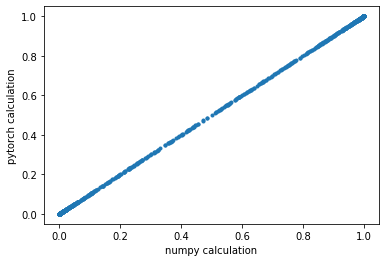

In [12]:
# Plot numpy vs pytorch model outputs
fig, ax = plt.subplots()
ax.plot(out_np, out_torch, '.')
ax.set_xlabel('numpy calculation')
ax.set_ylabel('pytorch calculation')

### 1.3) Repeat exercise 1.2 using PyTorch
We've provided the code for training the model here. 

First run it and check that the resulting loss curve looks the same as what you got in exercise 1.1. 

Then, try playing with the SGD parameters:
* What is the optimal batch size? Is larger batch size always better?
* What is the optimal learning rate? Is a larger learning rate always better? What happens if you make it too big?

In [13]:
# Initialize network, with initial weights set to 0
torch_model = logistic_model()
_ = nn.init.constant_(torch_model.linear.weight, 0)

# Set up SGD parameters
n_iter = 1000
batch_size = 50
alpha = 1e-8 / batch_size
optimizer = optim.SGD(torch_model.parameters(), lr=alpha) # this function will perform SGD for us!

# Set up loss function
def loss_fn(p, batch_labels):
    return - (torch.matmul(batch_labels, torch.log(p)) + torch.matmul((1 - batch_labels), torch.log(1 - p)))

In [14]:
# Placeholder for tracking loss
track_loss = []

# Loop over iterations
for i in range(n_iter):
    if i % 250 == 0: # every 250 iterations print the percent of iterations completed
        print('%.0f%% iterations completed...' % (100 * (i+1) / n_iter))
    # Sample random batch
    batch_index = rd.choice(len(regression_data), batch_size, replace=False)
    batch_images = torch.Tensor(regression_data[batch_index])
    batch_labels = torch.Tensor(regression_data_labels[batch_index])
    # Run the model on this batch of images to calculate estimated class probabilities    
    p = torch_model(batch_images)
    # Calculate loss for this batch
    loss = loss_fn(p, batch_labels)
    track_loss.append(loss.item()) # .item() necessary to take the torch tensor output and turn it into a number
    # Compute gradient of loss
    optimizer.zero_grad() # reset gradients (this is necessary for automatic differentiation algorithm)
    loss.backward()
    # Update weights
    optimizer.step()

0% iterations completed...
25% iterations completed...
50% iterations completed...
75% iterations completed...


Text(0, 0.5, 'loss')

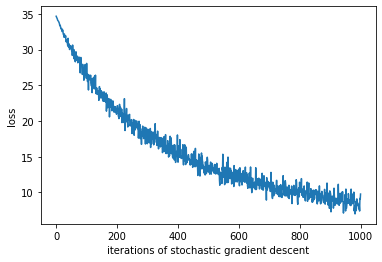

In [15]:
# Plot the loss
fig, ax = plt.subplots()
ax.plot(track_loss)
ax.set_xlabel('iterations of stochastic gradient descent')
ax.set_ylabel('loss')